# preprocessing of the data

Construct a comorbidity matrix

In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from scipy import stats, integrate
import statsmodels

In [2]:
file_in=open('../data/aggregated_by_line_has_age_gender.csv','r')
comorbidity_preprocessing={};
i=0;
for line in file_in.readlines():
    sp=line.split(',')
    temp_list_=[];
    for code in range(1,len(sp[3:]),2):
        disease_=sp[3+code].replace(')','').replace('\n','').replace('\'','').strip();
        if disease_ not in temp_list_:
            temp_list_.append(disease_);
    comorbidity_preprocessing[sp[0]]=temp_list_;
        


In [3]:
comorbidity={};
code_idx={};
idx=0;
for clique in comorbidity_preprocessing:
    diseases=comorbidity_preprocessing[clique];

    for i in diseases:
        if i not in code_idx:
            code_idx[i]=idx;
            idx+=1;
        for j in diseases:
            if( i==j):
                continue;
            key=tuple([i,j]);
            if key in comorbidity:
                comorbidity[key]+=1;
            else:
                comorbidity[key]=1;

In [4]:
comorbidity_matrix=np.zeros(shape=[2300,2300])
for i in comorbidity:
    comorbidity_matrix[code_idx[i[0]],code_idx[i[1]]]=comorbidity[i];

In [5]:
# Read clusters
file_in=open('../data/clusters/cluster_assignments.csv','r')
clusters={};
clusters_idx={};
for line in file_in.readlines():
    sp=line.split(',')
    clusters[sp[0]]=int(sp[2].replace('\n',''))
    clusters_idx[code_idx[sp[0]]]=int(sp[2].replace('\n',''));


In [6]:
len(clusters.keys())

729

# Analysis

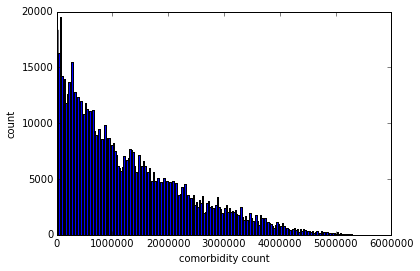

In [7]:
plt.hist(np.nonzero(comorbidity_matrix.flatten()),np.linspace(0,np.max(np.nonzero(comorbidity_matrix.flatten())),200))
plt.xlabel('comorbidity count')
plt.ylabel('count')

In [8]:
#how is the comorbiditiy between clusters
clusters_comorbidity=np.zeros(shape=[6,6]);
for i in comorbidity:
    if code_idx[i[0]] in clusters_idx and code_idx[i[1]] in clusters_idx:
        clusters_comorbidity[clusters_idx[code_idx[i[0]]]-1,clusters_idx[code_idx[i[1]]]-1]+=comorbidity[i];

In [9]:
clusters_size={i:0 for i in range(1,7)};
for i in clusters_idx:
    clusters_size[clusters_idx[i]]+=1.;

In [10]:
clusters_size={i:0 for i in range(1,7)};
for i in comorbidity.keys():
    print i
    clusters_size[clusters_idx[i[0]]]+=comorbidity[i];
    clusters_size[clusters_idx[i[1]]]+=comorbidity[i];

('L53', 'C20')


KeyError: 'L53'

In [ ]:
np.power(2,3)

In [ ]:
intra_cluster_edges={};
for i in range(1,7):
    intra_cluster_edges[i]=[];
for i in clusters_idx:
    in_=0;
    out_=np.zeros(7);
    for j in range(2300):
        if(j in clusters_idx):
                if comorbidity_matrix[i,j]>0:
                    out_[clusters_idx[j]]+=comorbidity_matrix[i,j];
        
    intra_cluster_edges[i]=out_;
        

In [ ]:
plt.plot(sorted(np.sum(comorbidity_matrix,axis=0)),'*')
plt.ylim([0,150000])

In [ ]:
intra_cluster_edges={};
for i in range(1,7):
    intra_cluster_edges[i]=[];
    for i in comorbidity:
        

In [ ]:
for i in range(1,7):
    plt.figure()
    plt.hist(sorted(intra_cluster_edges[i]))
    #plt.xlim([0,0.1])

In [ ]:
np.sum(comorbidity_matrix[:,1])

In [ ]:
normed_intra_cluster_edges={};
for i in range(0,19):
    normed_intra_cluster_edges[i]=intra_cluster_edges[i];
    for i_ in range(1,7):
        normed_intra_cluster_edges[i][i_]=normed_intra_cluster_edges[i][i_]/(clusters_size[clusters_idx[i]]*clusters_size[i_])
    print  clusters_idx[i],normed_intra_cluster_edges[i][1:]

# Conditional probability of diseases analysis

In [14]:
#normalization factor:
file_in=open('../data/aggregated_by_line_has_age_gender.csv','r')
P_d={};
P_xy={};
for line in file_in.readlines():
    sp=line.split(',')
    temp_list_=[];
    set_=[];
    for code in range(1,len(sp[3:]),2):
        disease_=sp[3+code].replace(')','').replace('\n','').replace('\'','').strip();
        if disease_ not in set_:
            set_.append(disease_);
    for _ in set_:    
        if _ in P_d:
            P_d[_]+=1;
        else:
            P_d[_]=1;
    past=[];
    for _1 in set_:
        for _2 in set_:
            key=tuple(sorted([_1,_2]));
            if(key not in past and _1!=_2):
                if( key in P_xy):
                    P_xy[key]+=1;
                else:
                    P_xy[key]=1;
            past.append(key);


In [120]:
# Read clusters
file_in=open('../code/cluster_assignments.csv','r')
clusters={};
clusters_idx={};
for line in file_in.readlines():
    sp=line.split(',')
    clusters[sp[0]]=int(sp[1].replace('\n',''))
    #clusters_idx[code_idx[sp[0]]]=int(sp[2].replace('\n',''));
print len(clusters)

345


In [100]:
#calculating conditionals
P_conditional={};
for _1 in range(1,7):
    for _2 in range(1,7):
        P_conditional[tuple([_1,_2])]={};
for i in P_xy:
    if i[0] in clusters and i[1] in clusters and P_xy[tuple([i[0],i[1]])]>100:
        P_conditional[tuple([clusters[i[0]],clusters[i[1]]])][tuple([i[0],i[1]])]=P_xy[tuple([i[0],i[1]])]*1.0/P_d[i[1]];
        P_conditional[tuple([clusters[i[1]],clusters[i[0]]])][tuple([i[1],i[0]])]=P_xy[tuple([i[0],i[1]])]*1.0/P_d[i[0]];

In [110]:
#relative risk comorbidity
comorbidity_network={}
for i in P_xy:
    if i[0] in clusters and i[1] in clusters:
        comorbidity_network[i]=P_xy[tuple(sorted(i))]*1.0/(P_d[i[0]]*P_d[i[1]])

list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]]]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]


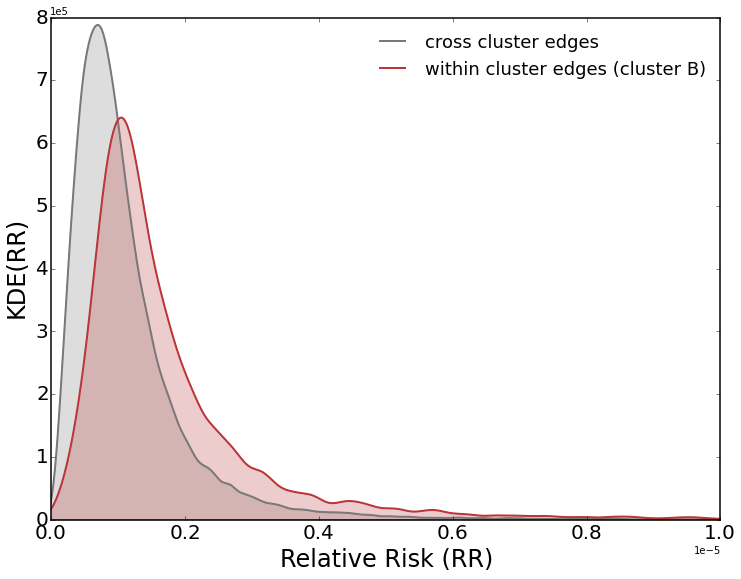

In [117]:
c_id=1;
b_w=10;
plt.rc('axes',linewidth=1.5)
 
list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]]]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]

plt.ticklabel_format(axis='x',style='scientific',useOffset=True)
fig=sns.kdeplot([i for i in list_2 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#79797a',linewidth=2,label='cross cluster edges')
fig=sns.kdeplot([i for i in list_1 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#bb3638',linewidth=2,label='within cluster edges (cluster B)'.format(c_id))
fig.figure.set_size_inches(12,9)

#fig.set_yscale('log')
plt.xlabel('Relative Risk (RR)', fontsize=24)
plt.xlim([0,1e-5])
plt.ylabel('KDE(RR)', fontsize=24)
plt.tick_params(labelsize=20)
fig.legend(fontsize=18,frameon=False)
#bacdef

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('RR_B.pdf')

([array([   27.,    73.,   118.,   210.,   307.,   445.,   603.,   799.,
           921.,   970.,  1049.,   944.,   901.,   761.,   685.,   587.,
           528.,   467.,   421.,   354.,   333.,   297.,   233.,   236.,
           214.,   203.,   173.,   177.,   137.,   107.,   125.,   137.,
            89.,    79.,    66.,    74.,    63.,    60.,    68.,    56.,
            34.,    35.,    40.,    48.,    54.,    38.,    42.,    33.,
            25.,    29.,    26.,    32.,    23.,     8.,    28.,    18.,
            27.,    28.,    13.,    14.,    13.,    17.,    13.,     8.,
             5.,    15.,    10.,     9.,    13.,     7.,     9.,    10.,
            10.,     9.,     8.,     7.,     4.,     9.,     7.,     7.,
             4.,     5.,     7.,    10.,     4.,    11.,     7.,     3.,
             5.,     3.,     3.,     4.,     5.,     7.,     6.,     9.,
             3.,     3.,     5.]),
  array([  1.61000000e+02,   8.86000000e+02,   1.65900000e+03,
           2.37300000e+03,

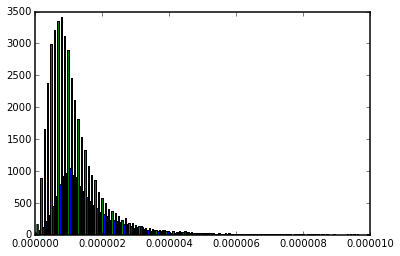

In [116]:
vals=[comorbidity_network[i] for i in comorbidity_network]
plt.hist([list_1,list_2],np.linspace(0,1e-5,100))


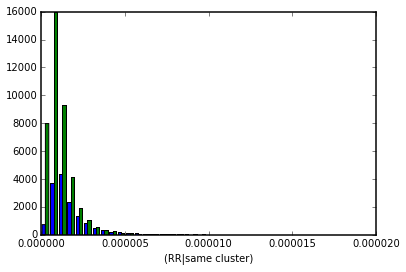

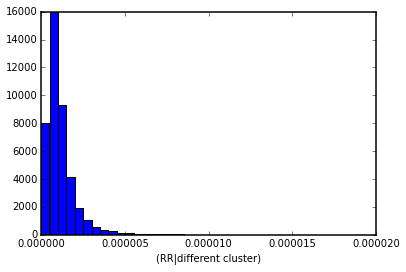

In [102]:
plt.hist([list_1,list_2] ,np.linspace(0,1e-4,200))
plt.xlim([0,2e-5])
plt.xlabel("(RR|same cluster)")
plt.figure()
plt.hist(list_2 ,np.linspace(0,1e-4,200))
plt.xlim([0,2e-5])
plt.xlabel("(RR|different cluster)")


In [95]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

In [96]:
list_11=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==1]
list_22=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==2]
list_33=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==3]
list_44=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==4]
list_55=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==5]
list_66=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==6]
list_nn=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]




In [122]:
#write comorbidity network for gephi
nodes_file=file('nodes.csv','w')
nodes_file.writelines('id,label,cluster\n')

for i in clusters:
    nodes_file.writelines('{},{},{}\n'.format(i,i,clusters[i]))

nodes_file.flush()
nodes_file.close()

#write comorbidity network for gephi
edges_file=file('edges.csv','w')
edges_file.writelines('source,target,weights,type\n')
list_1_cuttoff=sorted(list_1 + list_2)[-3000];
#list_2_cuttoff=sorted(list_2)[-1000];

for i in comorbidity_network:
    if(i[0] in clusters and i[1] in clusters):
        if clusters[i[0]]==clusters[i[1]] and comorbidity_network[i]>list_1_cuttoff:
            edges_file.writelines('{},{},{},{}\n'.format(i[0],i[1],comorbidity_network[i],'undirected'))
        
        if clusters[i[0]]!=clusters[i[1]] and comorbidity_network[i]>list_1_cuttoff:
            edges_file.writelines('{},{},{},{}\n'.format(i[0],i[1],comorbidity_network[i],'undirected'))
        
edges_file.flush()
edges_file.close()

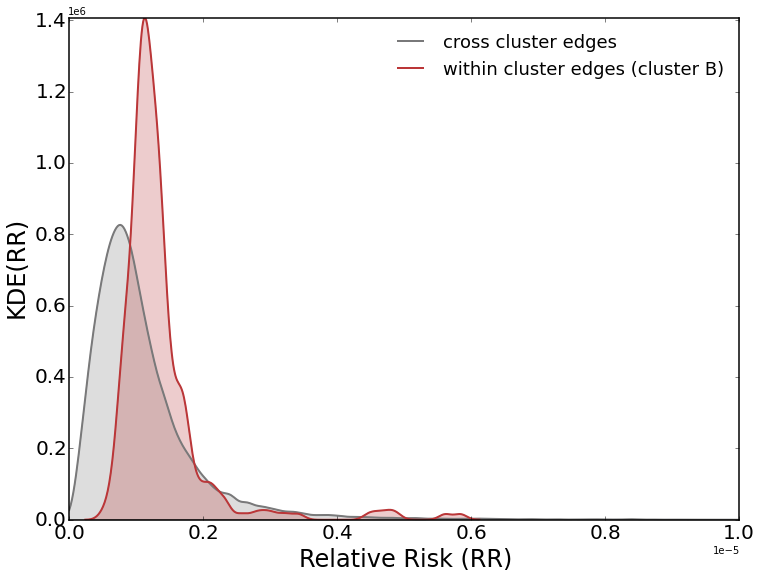

In [89]:
c_id=1;
b_w=10;
plt.rc('axes',linewidth=1.5)
 
list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==c_id]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]

plt.ticklabel_format(axis='x',style='scientific',useOffset=True)
fig=sns.kdeplot([i for i in list_2 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#79797a',linewidth=2,label='cross cluster edges')
fig=sns.kdeplot([i for i in list_1 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#bb3638',linewidth=2,label='within cluster edges (cluster B)'.format(c_id))
fig.figure.set_size_inches(12,9)

#fig.set_yscale('log')
plt.xlabel('Relative Risk (RR)', fontsize=24)
plt.xlim([0,1e-5])
plt.ylabel('KDE(RR)', fontsize=24)
plt.tick_params(labelsize=20)
fig.legend(fontsize=18,frameon=False)
#bacdef

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('RR_B.pdf')

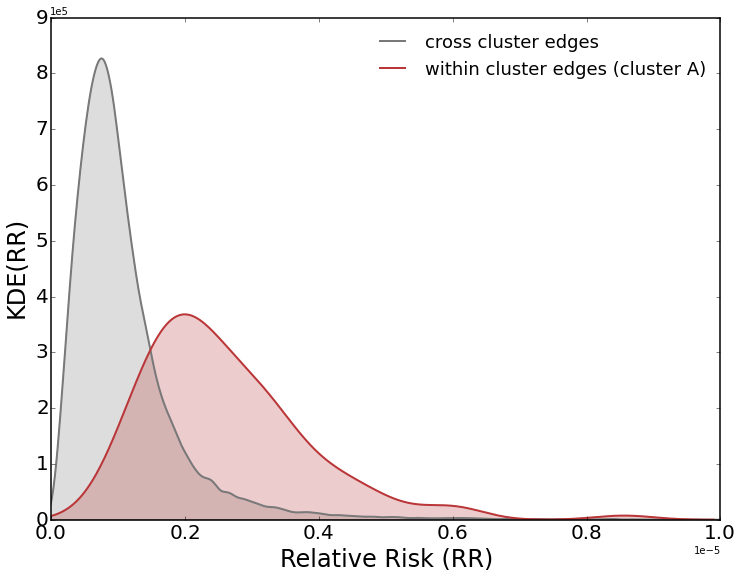

In [88]:
c_id=2;
b_w=10;
list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==c_id]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]

plt.ticklabel_format(axis='x',style='scientific',useOffset=True)
fig=sns.kdeplot([i for i in list_2 ],gridsize=300,shade=True, clip=(-0.1,1e-5),color='#79797a',linewidth=2,label='cross cluster edges')
fig=sns.kdeplot([i for i in list_1 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#bb3638',linewidth=2,label='within cluster edges (cluster A)')
fig.figure.set_size_inches(12,9)

#fig.set_yscale('log')
plt.xlabel('Relative Risk (RR)', fontsize=24)
plt.xlim([0,1e-5])
plt.ylabel('KDE(RR)', fontsize=24)
plt.tick_params(labelsize=20)
fig.legend(fontsize=18,frameon=False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('RR_A.pdf')

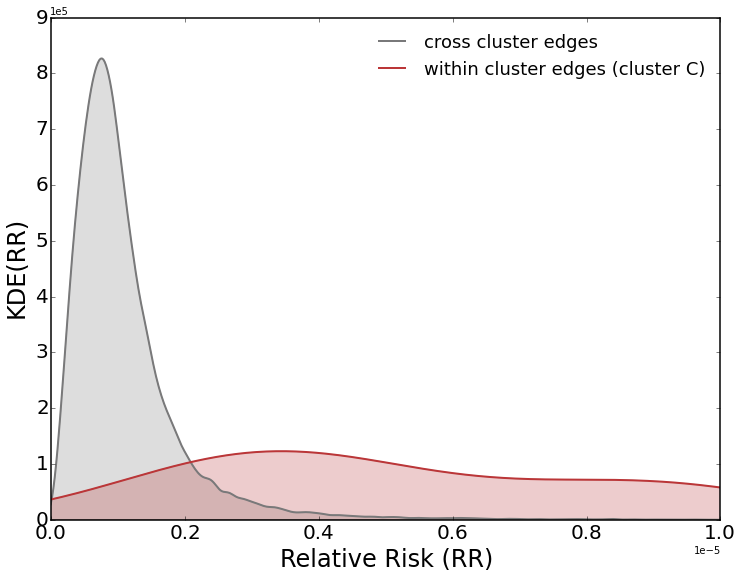

In [87]:
c_id=3;
b_w=10;
list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==c_id]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]

plt.ticklabel_format(axis='x',style='scientific',useOffset=True)
fig=sns.kdeplot([i for i in list_2 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#79797a',linewidth=2,label='cross cluster edges')
fig=sns.kdeplot([i for i in list_1 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#bb3638',linewidth=2,label='within cluster edges (cluster C)')
fig.figure.set_size_inches(12,9)

#fig.set_yscale('log')
plt.xlabel('Relative Risk (RR)', fontsize=24)
plt.xlim([0,1e-5])
fig.legend(fontsize=18,frameon=False)
plt.ylabel('KDE(RR)', fontsize=24)
plt.tick_params(labelsize=20)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('RR_C.pdf')

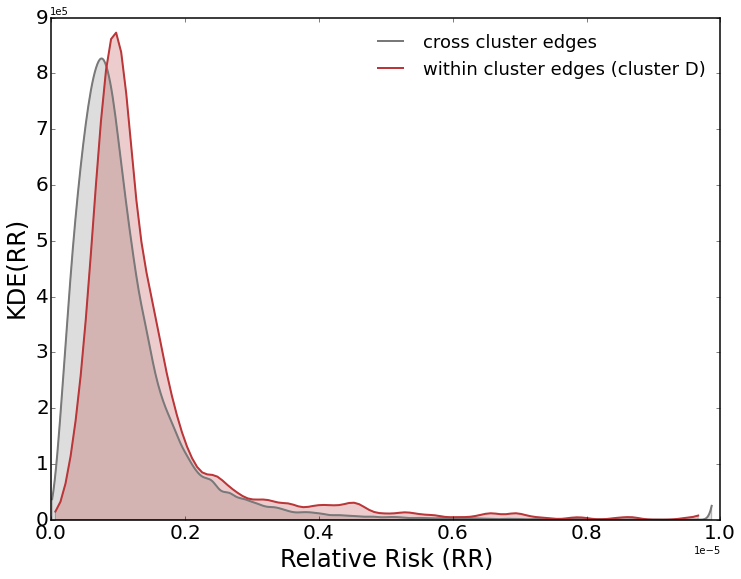

In [86]:
c_id=4;
b_w=10;
list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==c_id]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]

plt.ticklabel_format(axis='x',style='scientific',useOffset=True)
fig=sns.kdeplot([i for i in list_2 ],gridsize=300,shade=True,cut=0,clip=(-0.1,1e-5),color='#79797a',linewidth=2,label='cross cluster edges')
fig=sns.kdeplot([i for i in list_1 ],shade=True,cut=0,clip=(-0.1,1e-5),color='#bb3638',linewidth=2,label='within cluster edges (cluster D)')
fig.figure.set_size_inches(12,9)

#fig.set_yscale('log')
fig.legend(fontsize=18,frameon=False)
plt.xlabel('Relative Risk (RR)', fontsize=24)
plt.xlim([0,1e-5])
plt.ylabel('KDE(RR)', fontsize=24)
plt.tick_params(labelsize=20)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('RR_D.pdf')

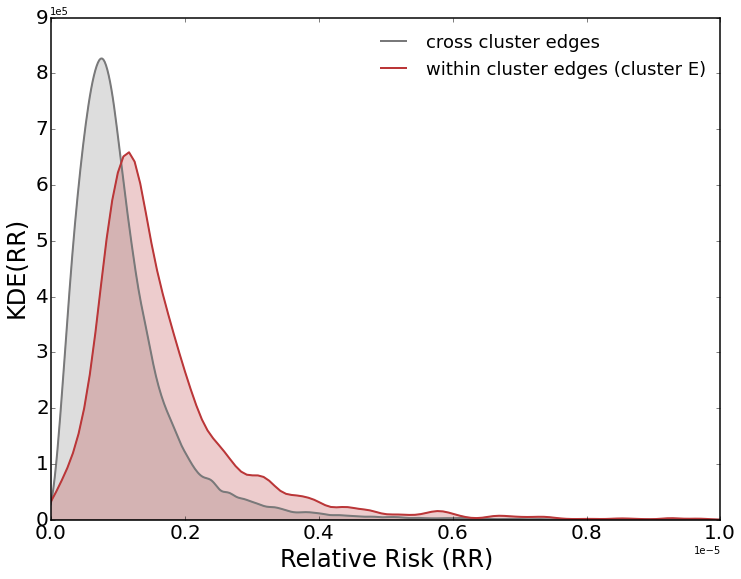

In [85]:
c_id=5;
b_w=10;
list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==c_id]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]

plt.ticklabel_format(axis='x',style='scientific',useOffset=True)
fig=sns.kdeplot([i for i in list_2 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#79797a',linewidth=2,label='cross cluster edges')
fig=sns.kdeplot([i for i in list_1 ],shade=True,clip=(-0.1,1e-5),color='#bb3638',linewidth=2,label='within cluster edges (cluster E)')
fig.figure.set_size_inches(12,9)

#fig.set_yscale('log')
plt.xlabel('Relative Risk (RR)', fontsize=24)
plt.xlim([0,1e-5])
plt.ylabel('KDE(RR)', fontsize=24)
fig.legend(fontsize=18,frameon=False)
plt.tick_params(labelsize=20)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('RR_E.pdf')

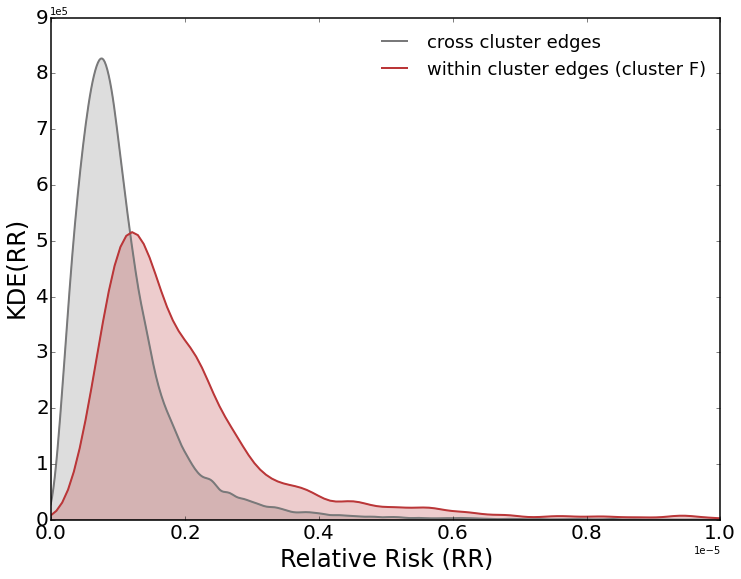

In [84]:
c_id=6;
b_w=10;
list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==c_id]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]

plt.ticklabel_format(axis='x',style='scientific',useOffset=True)
fig=sns.kdeplot([i for i in list_2 ],gridsize=300,shade=True,clip=(-0.1,1e-5),color='#79797a',linewidth=2,label='cross cluster edges')
fig=sns.kdeplot([i for i in list_1 ],shade=True,clip=(-0.1,1e-5),color='#bb3638',linewidth=2,label='within cluster edges (cluster F)')
fig.figure.set_size_inches(12,9)
fig.legend(fontsize=18,frameon=False)
#fig.set_yscale('log')
plt.xlabel('Relative Risk (RR)', fontsize=24)
plt.xlim([0,1e-5])
plt.ylabel('KDE(RR)', fontsize=24)
plt.tick_params(labelsize=20)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('RR_F.pdf')

([array([   21014.49275362,  1019202.89855072,   309963.76811594,
            42028.98550725,    26268.11594203,        0.        ,
            15760.86956522,     5253.62318841,    10507.24637681,
                0.        ,        0.        ,        0.        ,
                0.        ,        0.        ,        0.        ,
                0.        ,        0.        ,        0.        ,
                0.        ,        0.        ,        0.        ,
                0.        ,        0.        ,        0.        ,
                0.        ,        0.        ,        0.        ,
                0.        ,        0.        ]),
  array([  4.68624346e+05,   6.40739466e+05,   2.10651336e+05,
           6.67894519e+04,   2.85527403e+04,   1.36773616e+04,
           6.93851556e+03,   4.19305976e+03,   2.84529055e+03,
           1.99669513e+03,   1.09818232e+03,   9.98347563e+02,
           7.98678050e+02,   2.99504269e+02,   9.98347563e+01,
           3.99339025e+02,   4.99173781e+0

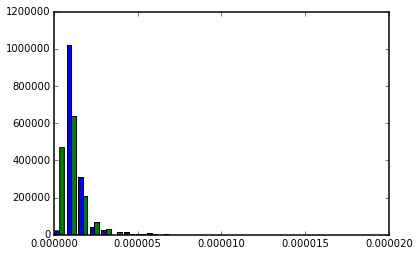

In [67]:
c_id=1;
list_1=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]==clusters[i[1]] and clusters[i[1]]==c_id]
list_2=[comorbidity_network[i] for i in comorbidity_network if clusters[i[0]]!=clusters[i[1]]]
plt.hist([list_1,list_2],np.linspace(0,2e-5,30),normed=True)

In [ ]:
clusters['M25']